In [1]:
INPUT_FILE="/content/drive/My Drive/datasets/C0003.MP4"
OUTPUT_PATH="/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/"

#------------------------------------------------------------------------------------------------------------------------------------
#MAYO csvファイル名に入力動画名を加えるため。#removed pathANDformat from videoFile  by mayo 
#------------------------------------------------------------------------------------------------------------------------------------
INPUT_FILE_splited_path=INPUT_FILE.split('/')
INPUT_FILE_removed_pathANDformat=INPUT_FILE_splited_path[-1].split(".")
INPUT_FILE_removed_pathANDformat=INPUT_FILE_removed_pathANDformat[0]

CSV_FILE= OUTPUT_PATH+ "pose-data_%s.csv" % INPUT_FILE_removed_pathANDformat
print(CSV_FILE)
OUTPUT_FILE= OUTPUT_PATH+ "pose_%s.MP4" % INPUT_FILE_removed_pathANDformat
print(OUTPUT_FILE)
#------------------------------------------------------------------------------------------------------------------------------------


/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0003.csv
/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/pose_C0003.MP4


In [2]:
import pandas as pd
import re

def read_file_keypoints(CSV_FILE):
    df=pd.read_csv(CSV_FILE, encoding = "shift-jis")
    df=df.set_index('frame')
    x_len, y_len=df.shape
    print(x_len, y_len)

    list_colums_name=list(df.columns)
    list_keypoints_label_x, list_keypoints_label_y= [], []
    list_keypoints_label_x.clear()
    list_keypoints_label_y.clear()
    for element in list_colums_name:
     if re.search('_y', element):
       list_keypoints_label_y.append(element)
     else:
       list_keypoints_label_x.append(element)

    df_keypoints_y=df.loc[:, list_keypoints_label_y]
    print(df_keypoints_y)
    list_coords_y=df_keypoints_y.values.tolist()
    #print(list_keypoints_y)

    print(max(list_coords_y))

    #print("list_keypoints_x", keypoints_x)
    #print("list_keypoints_y", keypoints_y)
      
    return df, list_coords_y, list_keypoints_label_y

df, list_coords_y, list_keypoints_label_y=read_file_keypoints(CSV_FILE)

print(list_coords_y)

200 34
       nose_y  left_eye_y  ...  left_ankle_y  right_ankle_y
frame                      ...                             
0         571         584  ...            20             11
1         571         584  ...            23             10
2         572         585  ...            26              9
3         569         586  ...            26              9
4         571         583  ...            24             12
...       ...         ...  ...           ...            ...
195       465         475  ...            95              8
196       461         475  ...            96              6
197       462         473  ...           103              4
198       461         471  ...           105              5
199       460         471  ...           106              6

[200 rows x 17 columns]
[572, 585, 585, 568, 568, 500, 500, 470, 380, 410, 402, 269, 278, 120, 150, 26, 9]
[[571, 584, 584, 567, 567, 502, 497, 467, 385, 406, 393, 272, 280, 120, 150, 20, 11], [571, 584, 584, 571

the directory already exists


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

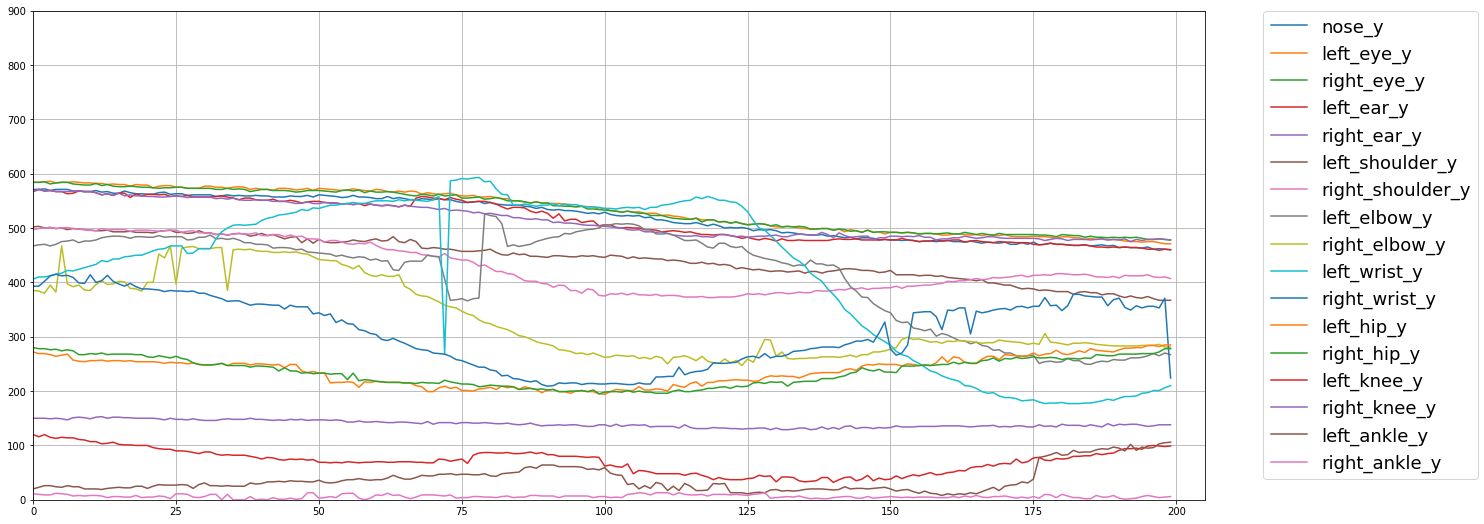

In [6]:
PARTS_FILE_01='A.MP4'
PARTS_PATH="./fig/"

from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib inline

from tqdm.autonotebook import tqdm

def AniFigure(PARTS_PATH, list_coords_y):
    try:
      import os 
      os.mkdir(PARTS_PATH)
    except:
      print('the directory already exists')

    # 描画領域
    fig = plt.figure()
    # 描画するデータ (最初は空っぽ)
    x = []
    y = []

    for frame in tqdm(range(0, len(list_coords_y),1)):
      """グラフを更新するための関数"""
      # 現在のグラフを消去する
      #print(frame)
      plt.cla()
      plt.clf()
      fig = plt.figure(figsize=(21,9))
      # データを更新 (追加) する
      x.append(frame)

      #print(list_coords_y[int(frame)])
      y.append(list_coords_y[int(frame)])
      # 折れ線グラフを再描画する
      plt.xlim((0, len(list_coords_y)+5))
      plt.ylim((0,900))
      plt.plot(x, y)
      plt.grid(True, axis='both')
      plt.legend(list_keypoints_label_y, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
      plt.savefig(PARTS_PATH+"/AniFig_%s.jpg" % (str(frame).zfill(5)), transparent = True, bbox_inches = 'tight', pad_inches = 0.1)
      #plt.show()

AniFigure(PARTS_PATH, list_coords_y)

In [8]:
def make_video(PATH, FILE):
  fps=59.94005994005994
  width =1920.0
  height =1080.0
  frames =270.0

  #画像結合
  import glob
  images = glob.glob(PATH + "*.jpg")
  from natsort import natsorted
  images=sorted(images)

  import cv2
  print("画像を結合して動画を作成します...")
  fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
  video = cv2.VideoWriter(PATH + FILE, fourcc, fps, (int(width), int(height)))

  from tqdm.autonotebook import tqdm
  for i in tqdm(range(len(images))):
     img = cv2.resize(cv2.imread(images[i]),(int(width),int(height)))
     video.write(img) 

  video.release()
  print("%sにおいて、\n%sを作成しました。" % (PATH, FILE))

make_video(PARTS_PATH, PARTS_FILE_01)

画像を結合して動画を作成します...



./fig/において、
A.MP4を作成しました。


https://watlab-blog.com/2019/09/29/movie-space-combine/

In [9]:
import cv2

# 2つの画像を横に連結する関数
def image_hcombine(im_info1, im_info2):
    img1 = im_info1[0]                       # 1つ目の画像
    img2 = im_info2[0]                       # 2つ目の画像
    color_flag1 = im_info1[1]                # 1つ目の画像のカラー/グレー判別値
    color_flag2 = im_info2[1]                # 2つ目の画像のカラー/グレー判別値

    # 1つ目の画像に対しカラーかグレースケールかによって読み込みを変える
    if color_flag1 == 1:
        h1, w1, ch1 = img1.shape[:3]         # 画像のサイズを取得（グレースケール画像は[:2]
    else:
        h1, w1 = img1.shape[:2]

    # 2つ目の画像に対しカラーかグレースケールかによって読み込みを変える
    if color_flag2 == 1:
        h2, w2, ch2 = img2.shape[:3]         # 画像のサイズを取得（グレースケール画像は[:2]
    else:
        h2, w2 = img2.shape[:2]

    # 2つの画像の縦サイズを比較して、大きい方に合わせて一方をリサイズする
    if h1 < h2:                              # 1つ目の画像の方が小さい場合
        h1 = h2                              # 小さい方を大きい方と同じ縦サイズにする
        w1 = int((h2 / h1) * w2)             # 縦サイズの変化倍率を計算して横サイズを決定する
        img1 = cv2.resize(img1, (w1, h1))    # 画像リサイズ
    else:                                    # 2つ目の画像の方が小さい場合
        h2 = h1                              # 小さい方を大きい方と同じ縦サイズにする
        w2 = int((h1 / h2) * w1)             # 縦サイズの変化倍率を計算して横サイズを決定する
        img2 = cv2.resize(img2, (w2, h2))    # 画像リサイズ

    img = cv2.vconcat([img1, img2])          # 2つの画像を横方向に連結
    return img

# 動画を空間方向に連結させる関数
def m_space_hcombine(movie1, movie2, path_out, scale_factor):
    path1 = movie1[0]                                       # 1つ目の動画のパス
    path2 = movie2[0]                                       # 2つ目の動画のパス
    color_flag1 = movie1[1]                                 # 1つ目の動画がカラーかどうか
    color_flag2 = movie2[1]                                 # 2つ目の動画がカラーかどうか

    # 2つの動画の読み込み
    movie1_obj = cv2.VideoCapture(path1)
    movie2_obj = cv2.VideoCapture(path2)

    # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
    i = 0                                                   # 第1ループ判定用指標
    while True:
        ret1, frame1 = movie1_obj.read()                    # 1つ目の動画のフレームを取得
        ret2, frame2 = movie2_obj.read()                    # 2つ目の動画のフレームを取得
        check = ret1 and ret2                               # 2つのフレームが共に取得できた時だけTrue（論理演算）
        if check == True:
            im_info1 = [frame1, color_flag1]                # 画像連結関数への引数1
            im_info2 = [frame2, color_flag2]                # 画像連結関数への引数2

            frame_mix = image_hcombine(im_info1, im_info2)  # 画像連結関数の実行

            if i == 0:
                # 動画ファイル保存用の設定
                fps = int(movie1_obj.get(cv2.CAP_PROP_FPS))                 # 元動画のFPSを取得
                fps_new = int(fps * scale_factor)                           # 動画保存時のFPSはスケールファクターをかける
                frame_size = frame_mix.shape[:3]                            # 結合したフレームのサイズを得る
                h = frame_size[0]                                           # フレームの高さサイズを取得
                w = frame_size[1]                                           # フレームの横サイズを取得
                fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')         # 動画保存時のfourcc設定（mp4用）
                video = cv2.VideoWriter(path_out, fourcc, fps_new, (w, h))  # 保存動画の仕様
                i = i + 1                                                   # 初期ループ判定用指標を増分
            else:
                pass
            video.write(frame_mix)                                          # 動画を保存する
        else:
            break

    # 動画オブジェクトの解放
    movie1_obj.release()
    movie2_obj.release()
    return

# ここからメイン実行文
movie1 = ['%s' % OUTPUT_FILE, True]     # 元動画のパス1, カラーはTrue
movie2 = [PARTS_PATH+PARTS_FILE_01,  True]    # 元動画のパス2, 白黒はFalse
path_out = 'movie_out.mp4'        # 保存する動画のパス
scale_factor = 1                  # FPSにかけるスケールファクター
path_out=OUTPUT_PATH +'movie_out.mp4' 

# 複数動画を連結させる関数を実行
m_space_hcombine(movie1, movie2, path_out, scale_factor)



---





---

